In [ ]:
!pip install timm

In [ ]:
# --- CELL 1: SETUP & IMPORT ---

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import time
import copy
import os
import random
from tqdm.auto import tqdm

# Kunci Random Seed (Agar adil)
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print(f"Random Seed dikunci ke: {seed}")

set_seed(42)

# Cek Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Hardware: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Random Seed dikunci ke: 42
Hardware: cuda
GPU: Tesla T4


In [ ]:
# --- CELL 2: MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# Buat folder checkpoint
checkpoint_dir = '/content/drive/My Drive/Tugas_ViT_Checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoint akan disimpan otomatis di: {checkpoint_dir}")

Mounted at /content/drive
Checkpoint akan disimpan otomatis di: /content/drive/My Drive/Tugas_ViT_Checkpoint


In [ ]:
# --- CELL 3: DATASET & DATALOADER ---
BATCH_SIZE = 32
NUM_CLASSES = 10 # CIFAR-10

# Transformasi (Augmentasi untuk Train)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Download Dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

# DataLoader (num_workers=0 AGAR TIDAK ERROR)
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
}

class_names = train_dataset.classes
print(f"Kelas: {class_names}")

100%|██████████| 170M/170M [00:16<00:00, 10.3MB/s]


Kelas: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**Inisialisasi 2 Model (Swin, DeiT)**

In [ ]:
# --- CELL 4: DEFINISI MODEL & PARAMETER ---
def get_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / (1024 ** 2)
    return total_params, trainable_params, model_size_mb

# Hanya 2 Model
model_names_dict = {
    'Swin': 'swin_tiny_patch4_window7_224',
    'DeiT': 'deit_tiny_patch16_224'
}

models = {}
print("--- METRIK A: JUMLAH PARAMETER ---")
for label, code_name in model_names_dict.items():
    print(f"\nInisialisasi {label}...")
    model = get_model(code_name, NUM_CLASSES)
    models[label] = model

    tot, train, size = count_parameters(model)
    print(f"Total Params: {tot:,}")
    print(f"Size (MB): {size:.2f} MB")

--- METRIK A: JUMLAH PARAMETER ---

Inisialisasi Swin...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Total Params: 27,527,044
Size (MB): 105.01 MB

Inisialisasi DeiT...


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Total Params: 5,526,346
Size (MB): 21.08 MB


In [ ]:
# --- CELL 5: FUNGSI TRAINING (AUTO-RESUME & BEST WEIGHTS) ---
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, dataloaders, criterion, optimizer, scheduler, model_name, num_epochs=10, patience=3):
    since = time.time()
    checkpoint_path = f'{checkpoint_dir}/{model_name}_checkpoint.pth'

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) # Simpan bobot awal

    start_epoch = 0
    early_stopping = EarlyStopping(patience=patience)

    # --- LOAD CHECKPOINT JIKA ADA ---
    if os.path.exists(checkpoint_path):
        print(f"--> Checkpoint ditemukan! Melanjutkan {model_name}...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        history = checkpoint['history']
        best_acc = checkpoint['best_acc']
        best_model_wts = checkpoint['best_model_wts'] # Load bobot terbaik yang tersimpan
        print(f"--> Lanjut dari Epoch {start_epoch+1} (Best Acc: {best_acc:.4f})")

    if start_epoch >= num_epochs:
        print("Model sudah selesai dilatih!")
        model.load_state_dict(best_model_wts) # Pastikan return yang terbaik
        return model, history

    # --- TRAINING LOOP ---
    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Progress Bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase}', unit='batch', leave=False)

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                scheduler.step()

            # Simpan model terbaik
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict()) # COPY BOBOT TERBAIK

                early_stopping(epoch_loss)

        # Save Checkpoint setiap epoch (termasuk best_model_wts)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'history': history,
            'best_model_wts': best_model_wts
        }, checkpoint_path)

        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # --- KUNCI: Load kembali bobot terbaik sebelum return ---
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
# --- CELL 6: START TRAINING SWIN ---
if 'results' not in locals(): results = {}
criterion = nn.CrossEntropyLoss()

print("=== TRAINING SWIN TRANSFORMER ===")
optimizer = optim.AdamW(models['Swin'].parameters(), lr=3e-5, weight_decay=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

models['Swin'], history_swin = train_model(
    models['Swin'], dataloaders, criterion, optimizer, scheduler,
    model_name='Swin', num_epochs=10
)
results['Swin'] = {'model': models['Swin'], 'history': history_swin}

=== TRAINING SWIN TRANSFORMER ===

Epoch 1/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.2456 Acc: 0.9210


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1233 Acc: 0.9595

Epoch 2/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0985 Acc: 0.9679


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0964 Acc: 0.9695

Epoch 3/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0678 Acc: 0.9776


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0845 Acc: 0.9736

Epoch 4/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0289 Acc: 0.9918


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0692 Acc: 0.9794

Epoch 5/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0227 Acc: 0.9927


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0685 Acc: 0.9797

Epoch 6/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0188 Acc: 0.9946


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0704 Acc: 0.9794

Epoch 7/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0162 Acc: 0.9956


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0701 Acc: 0.9795

Epoch 8/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0144 Acc: 0.9965


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.0696 Acc: 0.9799
Early stopping triggered!

Training selesai dalam 97m 13s
Best Val Acc: 0.9799


In [ ]:
# --- CELL 7: START TRAINING DEIT ---
print("=== TRAINING DEIT ===")
optimizer = optim.AdamW(models['DeiT'].parameters(), lr=3e-5, weight_decay=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

models['DeiT'], history_deit = train_model(
    models['DeiT'], dataloaders, criterion, optimizer, scheduler,
    model_name='DeiT', num_epochs=10
)
results['DeiT'] = {'model': models['DeiT'], 'history': history_deit}

=== TRAINING DEIT ===

Epoch 1/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.3221 Acc: 0.9008


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1900 Acc: 0.9388

Epoch 2/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.1380 Acc: 0.9551


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1395 Acc: 0.9533

Epoch 3/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0975 Acc: 0.9680


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1455 Acc: 0.9535

Epoch 4/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0444 Acc: 0.9867


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1055 Acc: 0.9655

Epoch 5/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0327 Acc: 0.9903


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1009 Acc: 0.9689

Epoch 6/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0264 Acc: 0.9927


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1044 Acc: 0.9673

Epoch 7/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0197 Acc: 0.9947


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1033 Acc: 0.9676

Epoch 8/10
--------------------


train:   0%|          | 0/1563 [00:00<?, ?batch/s]

train Loss: 0.0189 Acc: 0.9951


val:   0%|          | 0/313 [00:00<?, ?batch/s]

val Loss: 0.1032 Acc: 0.9680
Early stopping triggered!

Training selesai dalam 37m 33s
Best Val Acc: 0.9689


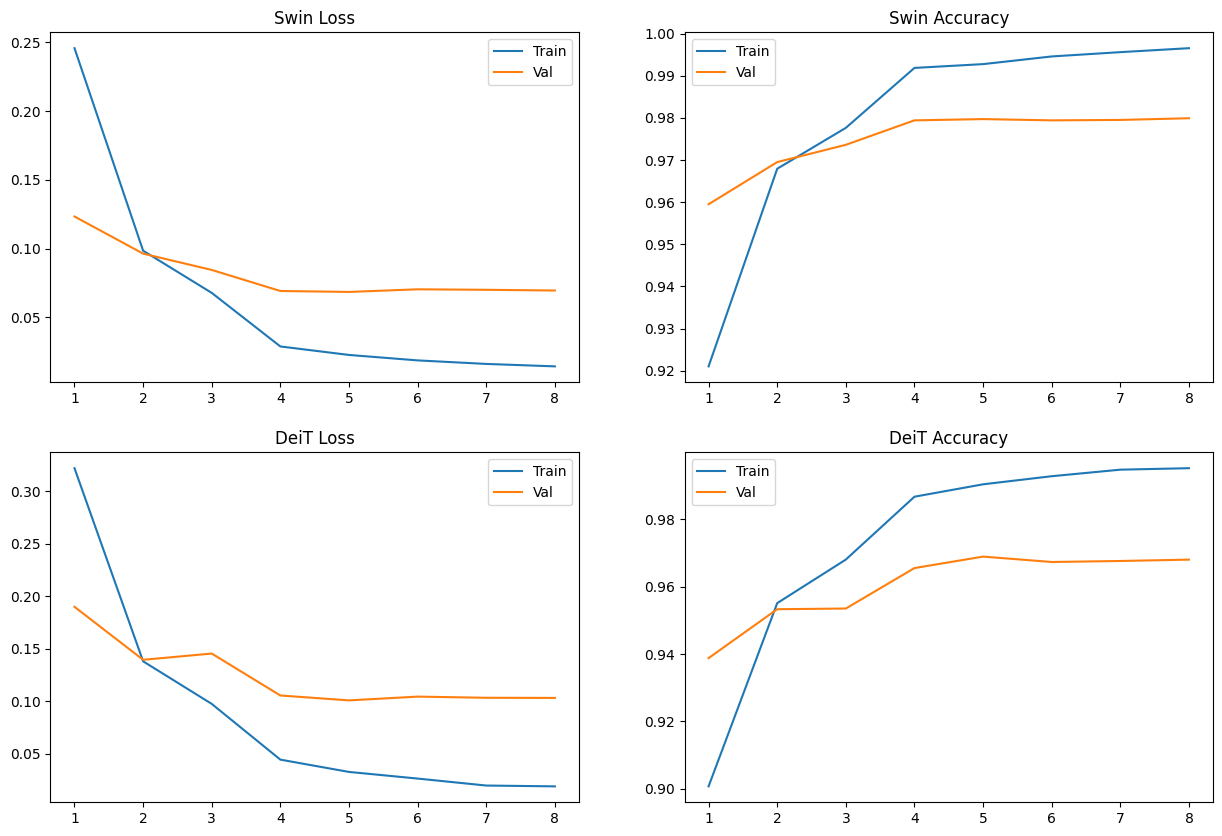

In [ ]:
# --- CELL 8: VISUALISASI HISTORY ---
def plot_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for idx, (name, data) in enumerate(results.items()):
        hist = data['history']
        epochs = range(1, len(hist['train_loss']) + 1)

        # Loss
        axes[idx, 0].plot(epochs, hist['train_loss'], label='Train')
        axes[idx, 0].plot(epochs, hist['val_loss'], label='Val')
        axes[idx, 0].set_title(f'{name} Loss')
        axes[idx, 0].legend()

        # Acc
        axes[idx, 1].plot(epochs, hist['train_acc'], label='Train')
        axes[idx, 1].plot(epochs, hist['val_acc'], label='Val')
        axes[idx, 1].set_title(f'{name} Accuracy')
        axes[idx, 1].legend()
    plt.show()

plot_results(results)

HASIL AKHIR PERBANDINGAN

Evaluating Swin...
Measuring inference time & accuracy...


  0%|          | 0/313 [00:00<?, ?it/s]

--- Hasil Swin ---
Accuracy  : 0.9799
F1-Score  : 0.9799
Inference : 3.64 ms ± 0.06 ms
Throughput: 274.52 img/sec


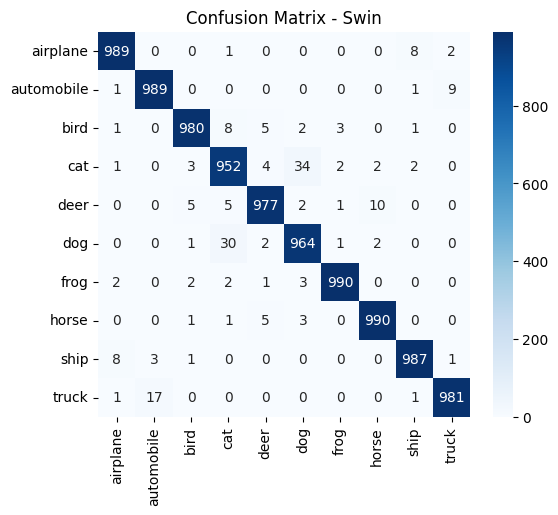


Evaluating DeiT...
Measuring inference time & accuracy...


  0%|          | 0/313 [00:00<?, ?it/s]

--- Hasil DeiT ---
Accuracy  : 0.9689
F1-Score  : 0.9689
Inference : 0.83 ms ± 0.05 ms
Throughput: 1200.69 img/sec


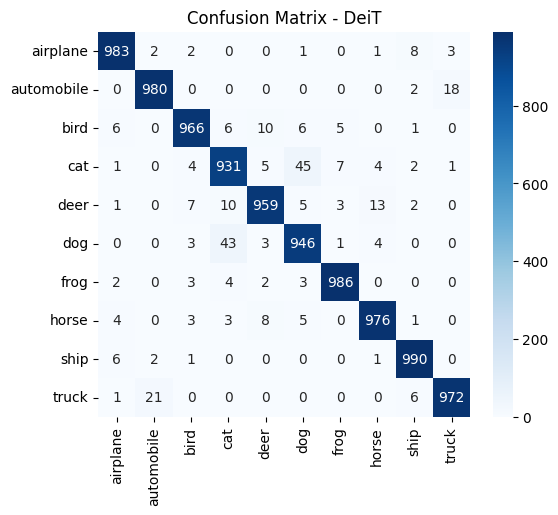


TABEL PERBANDINGAN:
Model  Accuracy  F1-Score  Latency (ms)  Throughput (img/s)
 Swin    0.9799  0.979906      3.642738          274.518760
 DeiT    0.9689  0.968896      0.832856         1200.687361


In [ ]:
# --- CELL 9: EVALUASI FINAL & INFERENSI ---
def evaluate_comprehensive(model, dataloader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    latencies = []

    print(f"\nEvaluating {model_name}...")

    # 1. Warm-up GPU (PENTING UNTUK POINT C)
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    for _ in range(20):
        with torch.no_grad(): _ = model(dummy_input)
    if device.type == 'cuda': torch.cuda.synchronize()

    # 2. Loop Evaluasi & Pengukuran Waktu
    print("Measuring inference time & accuracy...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            batch_size = inputs.size(0)

            # Sinkronisasi & Timer
            if device.type == 'cuda': torch.cuda.synchronize()
            start_t = time.time()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            if device.type == 'cuda': torch.cuda.synchronize()
            end_t = time.time()

            # Simpan Waktu (ms per image)
            latencies.append(((end_t - start_t) / batch_size) * 1000)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. Hitung Metrik
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Statistik Waktu Inferensi
    avg_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    throughput = 1000 / avg_latency

    print(f"--- Hasil {model_name} ---")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"Inference : {avg_latency:.2f} ms ± {std_latency:.2f} ms")
    print(f"Throughput: {throughput:.2f} img/sec")

    # Visualisasi Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return accuracy, f1, avg_latency, throughput

# Eksekusi Evaluasi
print(f"{'='*40}\nHASIL AKHIR PERBANDINGAN\n{'='*40}")
metrics_data = []
for name, model in models.items():
    acc, f1, lat, th = evaluate_comprehensive(model, dataloaders['val'], device, name)
    metrics_data.append([name, acc, f1, lat, th])

# Tampilkan Tabel Rangkuman
import pandas as pd
df = pd.DataFrame(metrics_data, columns=['Model', 'Accuracy', 'F1-Score', 'Latency (ms)', 'Throughput (img/s)'])
print("\nTABEL PERBANDINGAN:")
print(df.to_string(index=False))